In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
import itertools
import random
import json
import os

# Load data

In [2]:
import s3fs

s3 = s3fs.core.S3FileSystem(anon=True, client_kwargs={'endpoint_url': 'https://s3.cern.ch'})

In [3]:
flist = s3.glob('s3://jec-data/test/120*.root')

In [4]:
from utils.config import DataConfig
from utils.fileio import read_files
from utils.preprocess import build_new_variables, finalize_inputs

def get_data(data_config_file):
    data_config = DataConfig.load(data_config_file)
    table = read_files(flist, data_config.load_branches, s3)
    # define new variables
    build_new_variables(table, data_config.var_funcs)
    # perform input variable standardization, clipping, padding and stacking
    finalize_inputs(table, data_config)
    
    input_data = {key: table[f'_{key}'] for key in data_config.inputs.keys()}
    
    observers = ak.to_pandas({k: table[k] for k in data_config.observers})
    
    return input_data, observers

In [5]:
pfn_input_data, observers = get_data('https://raw.githubusercontent.com/deinal/weaver/dev/jet-energy-corrections/data/jec_pfn.yaml')
for key in pfn_input_data:
    print(key, pfn_input_data[key].shape)

ch_features (100000, 11, 64)
ch_mask (100000, 1, 64)
ne_features (100000, 6, 64)
ne_mask (100000, 1, 64)
sv_features (100000, 8, 16)
sv_mask (100000, 1, 16)
jet_features (100000, 7)


In [6]:
particlenet_input_data, _ = get_data('https://raw.githubusercontent.com/deinal/weaver/dev/jet-energy-corrections/data/jec_particle_net.yaml')
for key in particlenet_input_data:
    print(key, particlenet_input_data[key].shape)

ch_points (100000, 2, 64)
ch_features (100000, 11, 64)
ch_mask (100000, 1, 64)
ne_points (100000, 2, 64)
ne_features (100000, 6, 64)
ne_mask (100000, 1, 64)
sv_points (100000, 2, 16)
sv_features (100000, 8, 16)
sv_mask (100000, 1, 16)
jet_features (100000, 7)


In [7]:
observers.head()

,pt,pt_gen,pt_full_corr,eta_gen,parton_flavor,hadron_flavor
entry,,,,,,
0,158.340561,168.027435,177.802567,2.158748,21.0,0.0
1,374.658142,426.063812,395.626251,0.194441,5.0,5.0
2,555.531433,628.062805,597.043030,-0.866555,21.0,0.0
3,200.639389,201.832901,213.801086,2.530275,5.0,5.0
4,750.133179,771.528503,820.823792,-1.082310,4.0,4.0


In [8]:
observers.shape

(100000, 6)

In [9]:
data_len = observers.shape[0]

In [10]:
outdir = 'figs/data'

try:
    for ext in ['png', 'pdf']:
        os.makedirs(os.path.join(outdir, ext))
except FileExistsError:
    pass

In [11]:
df = observers
df['flavour'] = df.hadron_flavor.where(df.hadron_flavor != 0, other=np.abs(df.parton_flavor))

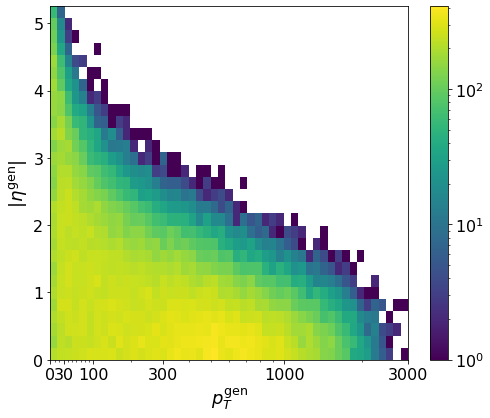

<Figure size 432x288 with 0 Axes>

In [12]:
from utils.visualize_data import plot_spectrum

plot_spectrum(df, outdir)

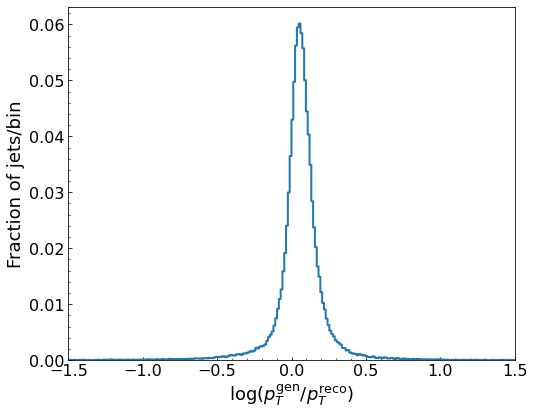

<Figure size 432x288 with 0 Axes>

In [13]:
from utils.visualize_data import plot_target

plot_target(np.log(df.pt_gen / df.pt), outdir)

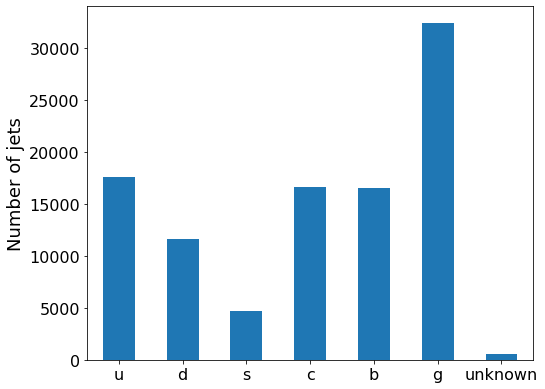

In [14]:
from utils.visualize_data import plot_flavour_bars

plot_flavour_bars(df, outdir)

# Triton inference

### Set up client

In [15]:
import tritonclient.http as httpclient

In [16]:
pfn_triton_client = httpclient.InferenceServerClient(url='pfn-regressor-ea37f4.dholmber.svc.cluster.local', verbose=False)
particlenet_triton_client = httpclient.InferenceServerClient(url='particle-net-regressor-25a03c.dholmber.svc.cluster.local', verbose=False)

In [17]:
def infer(triton_client, inputs):
    triton_inputs = []
    for i, key in enumerate(inputs.keys()):
        triton_inputs.append(httpclient.InferInput(name=key, shape=inputs[key].shape, datatype="FP32"))
        triton_inputs[i].set_data_from_numpy(inputs[key])

    triton_outputs = [httpclient.InferRequestedOutput(name='output')]

    results = triton_client.infer(
        model_name='optimal',
        inputs=triton_inputs,
        outputs=triton_outputs
    )
    return results

### Initialize inference experiment parameters

In [77]:
num_repeats = 10
batch_sizes = range(10, 1010, 10)

### Gather statistics

In [81]:
def gather_statistics(triton_client, input_data, num_repeats, batch_sizes):
    batch_stats = {batch_size: {'inference_time': [], 'inference_count': 0, 'total_inference_time': 0} for batch_size in batch_sizes}
    
    statistics = triton_client.get_inference_statistics(model_name='optimal')
    initial_batch_stats = statistics['model_stats'][0]['batch_stats']

    for initial_stat in initial_batch_stats:
        batch_size = initial_stat['batch_size']
        if batch_size in batch_sizes:
            initial_inference = initial_stat['compute_infer']
            batch_stats[batch_size]['total_inference_time'] = initial_inference['ns']

    for batch_size in tqdm(batch_sizes):
        while batch_stats[batch_size]['inference_count'] < num_repeats:
            indices = random.sample(range(data_len), batch_size)
            inputs = {}
            for key in input_data:
                inputs[key] = input_data[key][indices]

            results = infer(triton_client, inputs)

            statistics = triton_client.get_inference_statistics(model_name='optimal')
            all_current_batch_stats = statistics['model_stats'][0]['batch_stats']
            for stat in all_current_batch_stats:
                if stat['batch_size'] == batch_size:
                    current_batch = stat
                    break

            last_inference_time = current_batch['compute_infer']['ns'] - batch_stats[batch_size]['total_inference_time']

            batch_stats[batch_size]['inference_time'].append(last_inference_time / batch_size)
            batch_stats[batch_size]['total_inference_time'] = current_batch['compute_infer']['ns']
            batch_stats[batch_size]['inference_count'] += 1
    
    return batch_stats

In [82]:
pfn_batch_stats = gather_statistics(pfn_triton_client, pfn_input_data, num_repeats, batch_sizes)

100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


In [85]:
particle_net_batch_stats = gather_statistics(particlenet_triton_client, particlenet_input_data, num_repeats, batch_sizes)

100%|██████████| 100/100 [13:09<00:00,  7.89s/it]


### Calculate metrics

In [86]:
def calculate_metrics(batch_stats, batch_sizes):
    y = []
    yerr = []
    for batch_size in batch_sizes:
        batch_inference_time = [t / 1000 for t in batch_stats[batch_size]['inference_time']]

        summed_time = sum(batch_inference_time)
        count = batch_stats[batch_size]['inference_count']
        if not count:
            continue

        mean_time = summed_time / count
        y.append(mean_time)

        sem = np.std(batch_inference_time, ddof=1) / np.sqrt(np.size(batch_inference_time))
        yerr.append(sem)
    
    return y, yerr

In [87]:
pfn_y, pfn_yerr = calculate_metrics(pfn_batch_stats, batch_sizes)

In [89]:
particlenet_y, particlenet_yerr = calculate_metrics(particle_net_batch_stats, batch_sizes)

### Plot inference time

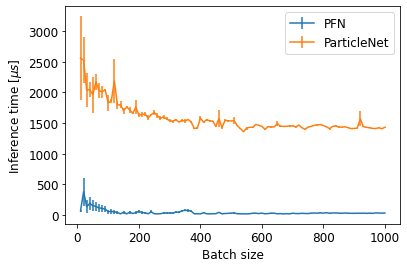

In [90]:
plt.errorbar(x=batch_sizes, y=pfn_y, yerr=pfn_yerr, label='PFN')
plt.errorbar(x=batch_sizes, y=particlenet_y, yerr=particlenet_yerr, label='ParticleNet')
plt.xlabel('Batch size', fontsize=12)
plt.ylabel('Inference time [$\mu s$]', fontsize=12)
plt.legend()
plt.savefig('figs/inference_time.png')
plt.show()

# Physics results

In [18]:
batch_size = 100

In [19]:
def get_predictions(triton_client, input_data):
    predictions = []

    for i in tqdm(range(0, data_len, batch_size)):
        inputs = {}
        for key in input_data:
            inputs[key] = input_data[key][i:i+batch_size]

        results = infer(triton_client, inputs)

        predictions.append(results.as_numpy(name='output'))

    return np.concatenate(predictions)

In [20]:
pfn_triton_client = httpclient.InferenceServerClient(url='pfn-regressor-ea37f4.dholmber.svc.cluster.local', verbose=False)

pfn_predictions = get_predictions(pfn_triton_client, pfn_input_data)

100%|██████████| 1000/1000 [00:18<00:00, 55.35it/s]


In [42]:
particlenet_triton_client = httpclient.InferenceServerClient(url='particle-net-regressor-25a03c.dholmber.svc.cluster.local', verbose=False)

particlenet_predictions = get_predictions(particlenet_triton_client, particlenet_input_data)

100%|██████████| 1000/1000 [03:23<00:00,  4.91it/s]


In [43]:
outdir = 'figs'
network_names = ['PFN-r', 'ParticleNet-r']
names = ['Standard'] + network_names
preds = {'PFN-r': pfn_predictions.squeeze(), 'ParticleNet-r': particlenet_predictions.squeeze()}

In [70]:
df['flavour'] = df.hadron_flavor.where(df.hadron_flavor != 0, other=np.abs(df.parton_flavor))
df['Standard'] = df.pt_full_corr / df.pt_gen
for name in network_names:
    corrected_pt = np.exp(preds[name]) * df.pt
    df[name] = corrected_pt / df.pt_gen

binning = np.geomspace(20, 3000, 20)
bin_centers = np.sqrt(binning[:-1] * binning[1:])

In [71]:
df

,pt,pt_gen,pt_full_corr,eta_gen,parton_flavor,hadron_flavor,flavour,Standard,PFN-r,ParticleNet-r
entry,,,,,,,,,,
0,158.340561,168.027435,177.802567,2.158748,21.0,0.0,21.0,1.058176,1.059072,1.044822
1,374.658142,426.063812,395.626251,0.194441,5.0,5.0,5.0,0.928561,0.922834,0.924089
2,555.531433,628.062805,597.043030,-0.866555,21.0,0.0,21.0,0.950610,0.957109,0.947163
3,200.639389,201.832901,213.801086,2.530275,5.0,5.0,5.0,1.059297,1.095388,1.099720
4,750.133179,771.528503,820.823792,-1.082310,4.0,4.0,4.0,1.063893,1.051344,1.057534
...,...,...,...,...,...,...,...,...,...,...
99995,1094.819458,1143.355225,1161.512085,0.735760,5.0,5.0,5.0,1.015880,0.987814,0.995209
99996,493.650116,580.020508,545.684143,-1.167677,4.0,4.0,4.0,0.940801,0.950394,0.930787
99997,66.017899,75.078667,71.055115,1.445241,2.0,0.0,2.0,0.946409,1.013242,1.061865


In [56]:
try:
    os.makedirs(outdir)
except FileExistsError:
    pass

for subdir in ['distributions', 'flavours', 'response', 'resolution', 'residual']:
    try:
        for ext in ['png', 'pdf']:
            os.makedirs(os.path.join(outdir, subdir, ext))
    except FileExistsError:
        pass

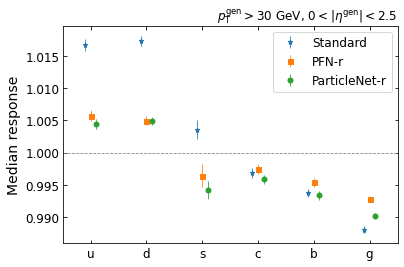

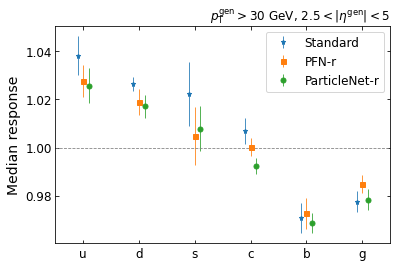

In [59]:
%%capture --no-display
from utils.plot import compare_flavours

compare_flavours(df, names, os.path.join(outdir, 'flavours'))

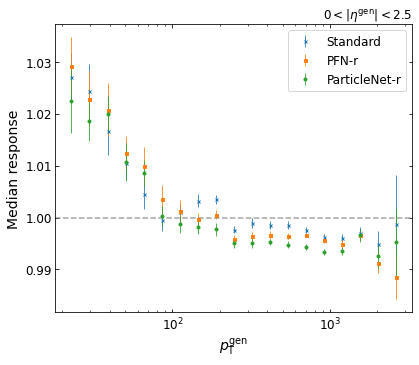

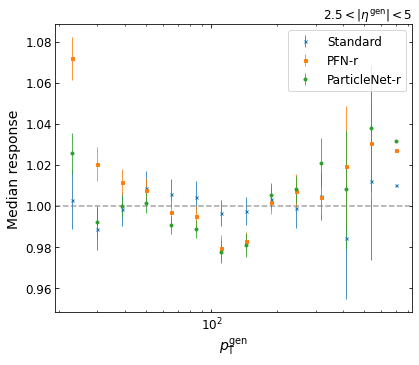

In [60]:
from utils.plot import plot_median_response

for (ieta, eta_bin), (flavour_label, flavour_ids) in itertools.product(
    enumerate([(0, 2.5), (2.5, 5)], start=1),
    [
        ('uds', {1, 2, 3}), ('c', {4}), ('b', {5}), ('g', {21}),
        ('all', {0, 1, 2, 3, 4, 5, 21})
    ]
):
    df_bin = df[
        (np.abs(df.eta_gen) >= eta_bin[0])
        & (np.abs(df.eta_gen) < eta_bin[1])
        & df.flavour.isin(flavour_ids)
    ]
    bins = df_bin.groupby(pd.cut(df_bin.pt_gen, binning))

    plot_median_response(
        os.path.join(outdir, 'response'),
        flavour_label, bins, bin_centers, eta_bin, ieta, names
    )

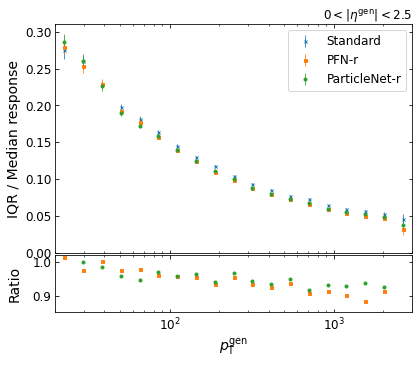

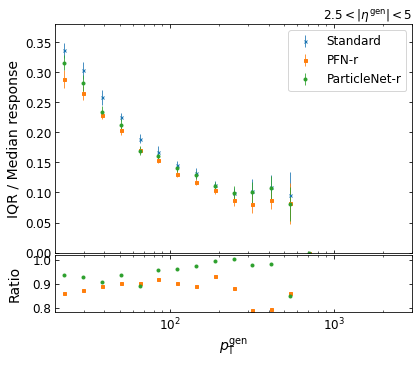

In [61]:
from utils.plot import plot_resolution, compute_resolution_improvement, to_serializable

data = {}
for (ieta, eta_bin), (flavour_label, flavour_ids) in itertools.product(
    enumerate([(0, 2.5), (2.5, 5)], start=1),
    [
        ('uds', {1, 2, 3}), ('c', {4}), ('b', {5}), ('g', {21}),
        ('all', {0, 1, 2, 3, 4, 5, 21})
    ]
):
    df_bin = df[
        (np.abs(df.eta_gen) >= eta_bin[0])
        & (np.abs(df.eta_gen) < eta_bin[1])
        & df.flavour.isin(flavour_ids)
    ]
    bins = df_bin.groupby(pd.cut(df_bin.pt_gen, binning))

    data[f'{flavour_label}_eta{ieta}'] = plot_resolution(
        os.path.join(outdir, 'resolution'),
        flavour_label, bins, bin_centers, eta_bin, ieta, binning, names
    )

    for (ipt, pt_bin) in enumerate(
            [(30, np.inf), (30, 50), (50, 100), (100, 300), (300, 1000), (1000, np.inf)], start=1
        ):
        pt_bin = df_bin[
            (df_bin.pt_gen >= pt_bin[0])
            & (df_bin.pt_gen < pt_bin[1])
        ]
        data[f'{flavour_label}_eta{ieta}']['improvement'][f'pt{ipt}'] = compute_resolution_improvement(pt_bin, names)

with open(os.path.join(outdir, 'resolution', 'data.json'), 'w') as f:
    json.dump(data, f, indent='\t', default=to_serializable)

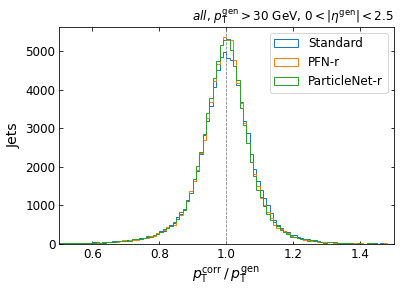

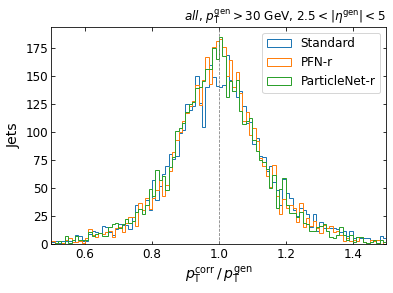

In [62]:
from utils.plot import plot_distrs

plot_distrs(df, names, os.path.join(outdir, 'distributions'))

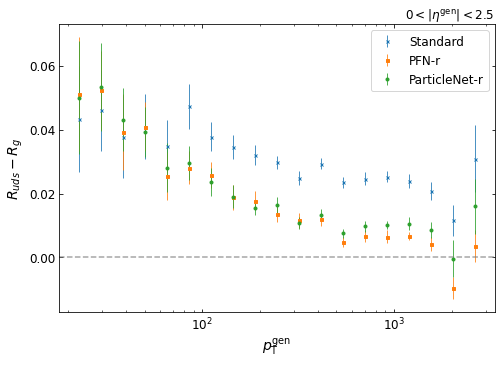

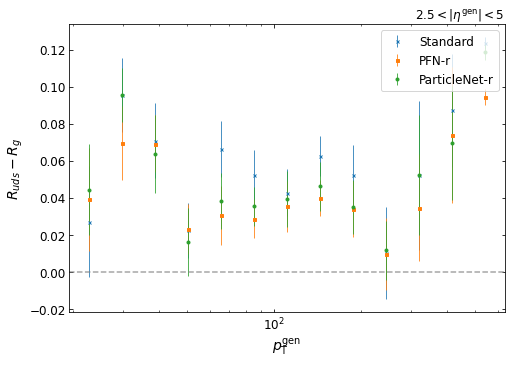

In [63]:
from utils.plot import plot_median_residual

for (ieta, eta_bin), flavours in itertools.product(
    enumerate([(0, 2.5), (2.5, 5)], start=1),
    itertools.combinations([('uds', {1, 2, 3}), ('c', {4}), ('b', {5}), ('g', {21})], r=2),
):
    bins = []
    for i, flavour_ids in enumerate([flavours[0][1], flavours[1][1]]):
        df_bin = df[
            (np.abs(df.eta_gen) >= eta_bin[0])
            & (np.abs(df.eta_gen) < eta_bin[1])
            & df.flavour.isin(flavour_ids)
        ]
        bins.append(df_bin.groupby(pd.cut(df_bin.pt_gen, binning)))

    plot_median_residual(
        os.path.join(outdir, 'residual'),
        bin_centers, (flavours[0][0], flavours[1][0]), bins, eta_bin, ieta, names
    )